In [1]:
import random
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint

import itertools
import scipy
import scipy.integrate as spi
from scipy.integrate import quad
from scipy.special import erf,erfc
#import cvxpy as cp

from sympy import symbols, solve
from scipy.optimize import fsolve, root
from numpy.polynomial import polynomial as P

In [2]:
print(scipy.__version__)

1.10.1


In [3]:
def maxim(r,p,beta,alpha):

    def Delta(b,r=r,p=p):
        log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
        return -np.dot(p,log)

    lamb=np.log(beta)/np.log(alpha)

    def constraint1(b,r=r,p=p,lamb=lamb):
        return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1

    def constraint2(b):
        return np.sum(b)-1

    nonlinear_constraint = NonlinearConstraint(constraint1, lb=float('-inf'), ub=0)

    # Define the bounds as before
    bounds = [(0, 1), (0, 1), (0, 1)]

    #constraint_dict_ineq = {'type': 'ineq', 'fun': constraint1}

    # Define the equality constraint dictionary
    constraint_dict_eq = {'type': 'eq', 'fun': constraint2}


    # Minimize the negative of the objective function
    res = minimize(Delta, [1/3, 1/3, 1/3], bounds=bounds, constraints=[nonlinear_constraint, constraint_dict_eq])
    #print(res.x)

    log=(np.log(res.x[0]/r[0]),np.log(res.x[1]/r[1]),np.log(res.x[2]/r[2]))
    log2=((np.log(res.x[0]/r[0]))**2,(np.log(res.x[1]/r[1]))**2,(np.log(res.x[2]/r[2]))**2)
    sigma=(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
    # The maximum value of the original function is the negative of the minimum value found above
    max_value = -res.fun

    return max_value,sigma,res.x

----New choices of p and r----
p =  [0.2320167  0.34203346 0.42594984]
r =  [0.23091087 0.46743751 0.30165163]
Color:  r
----New choices of p and r----
p =  [0.07124681 0.76351391 0.16523928]
r =  [0.89746007 0.04088802 0.06165191]
Color:  b


/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_88405/910920072.py:4: RuntimeWarning: divide by zero encountered in log
  log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
/var/folders/nj/8_y549ys3w95k2y8dz3k68_m0000gn/T/ipykernel_88405/910920072.py:10: RuntimeWarning: divide by zero encountered in scalar power
  return (p[0]*(b[0]/r[0])**(-lamb)+p[1]*(b[1]/r[1])**(-lamb)+p[2]*(b[2]/r[2])**(-lamb))-1


----New choices of p and r----
p =  [0.5426186 0.1989967 0.2583847]
r =  [0.19396225 0.23579645 0.57024131]
Color:  g


Text(0, 0.5, '$P_{ext}$')

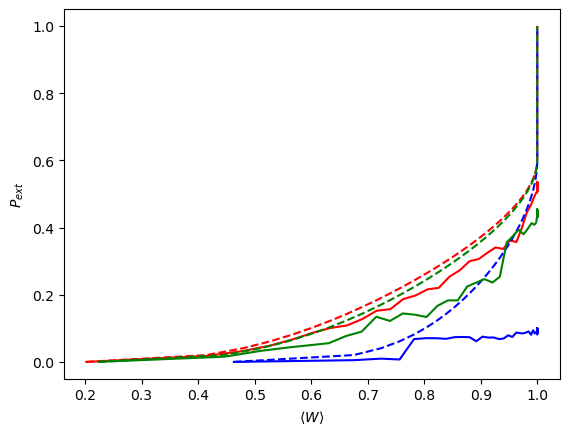

In [5]:
#Computes P_ext by simulation for the b's obtained by Boyd's method. Compares bound with actual P_ext
#For 3 horses
betas=np.linspace(0.0001,1,50)
#Defining functions

def horse_wins(p):
    #Do the race!
    limits=np.cumsum(p)
    random_num=(random.uniform(0,1))
    #print(random_num)
    check=(random_num<=limits)
    indice_caballo=0
    while ~check[indice_caballo]:
      indice_caballo+=1
    return indice_caballo

#Declaring variables
b0_opt=np.zeros_like(betas)
b1_opt=np.zeros_like(betas)
b2_opt=np.zeros_like(betas)
W_opt=np.zeros_like(betas)
sigma_opt=np.zeros_like(betas)
P_ext=np.zeros_like(betas)
#Common parameters

#For races simulation
alpha=0.6 #Sets the threshold (alpha) for the capital
threshold=np.log(alpha)
initial_capital=1
num_realizations=4000 #number of realizations for P_ext computation.
num_races=100;

#The number of colors define how many p's and r's combinations we are doing
colors=['r','b','g']
#colors=['r','b']

for l in range(0,len(colors)):
  #p=(0.1,0.2,0.7)
  #r=(0.7,0.1,0.2)
  #Define the gambling game
    p=np.random.uniform(0,1,3)
    p=p/sum(p)
    r=np.random.uniform(0,1,3)
    r=r/sum(r)

  print("----New choices of p and r----")
  print("p = ",p)
  print("r = ",r)
  print("Color: ",colors[l])
  #Maximize W with constraints using maxim() for different betas
  for i in range(0,len(betas)):
    waux,sigmaaux,[b0_opt[i],b1_opt[i],b2_opt[i]]=maxim(r,p,betas[i],alpha)
    b0=b0_opt[i]
    b1=b1_opt[i]
    b2=b2_opt[i]
    log=(np.log(b0/r[0]),np.log(b1/r[1]),np.log(b2/r[2]))
    log2=((np.log(b0/r[0]))**2,(np.log(b1/r[1]))**2,(np.log(b2/r[2]))**2)
    W_opt[i]=(np.dot(p,log))
    #sigma_opt[i]=(np.sqrt(np.dot(p,log2)-(np.dot(p,log))**2))
  #Simulation with optimal b's

  for i in range(0,len(betas)):
    b=np.array([b0_opt[i],b1_opt[i],b2_opt[i]])
    #b=p#Kelly's
    #print(f"Iteration {i} of {len(betas)}")
    #print("beta= ",betas[i])
    #print("b=[",b,"]")
    #print("Deltas:",np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
    log_capital=np.zeros(num_races);
    log_capital[0]=np.log(initial_capital)
    extinctions=0
    for j in range(0,num_realizations-1): #realizations for
      for k in range(1,num_races): #races for loop
        #Which horse wins? Do the race
        horse=horse_wins(p)
        #print("horse wins:",horse)
        #Compute capital increase
        log_capital[k]=log_capital[k-1]+np.log(b[horse]/r[horse])
        if log_capital[k]<=threshold:
          extinctions=extinctions+1
          break #we can stop simulating once is extinct
      #plt.plot(log_capital)
      #Normalize number of extinctions
    P_ext[i]=extinctions/num_realizations
    #print("Num Extinctions: ",extinctions)
    #print("P_ext: ",P_ext[i])
    #print(alpha)
    #print(P_ext_J)
  plt.plot(W_opt/max(W_opt),P_ext,colors[l])
  plt.plot(W_opt/max(W_opt),betas,colors[l]+"--")
plt.xlabel(r'$\langle W\rangle$')
plt.ylabel(r'$P_{ext}$')
#log=(np.log(b[0]/r[0]),np.log(b[1]/r[1]),np.log(b[2]/r[2]))
#print(np.dot(p,log))

#Uncomment to save figure
#plt.savefig('Pext_Boyd.pdf')